# **Legal Document Node Classification with Graph ML**

Building a node classifier for legal documents using graph machine learning. In here classify your 25 documents into 5 categories based on both content and relationships between documents.


### **Environment Setup and Dependencies**

In [ ]:
# Install required libraries
%pip install torch torch_geometric networkx pandas matplotlib scikit-learn sentence-transformers python-docx spacy


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 69.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 55.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24

In [ ]:
# import json

# # Load the notebook
# notebook_path = r"c:\Users\npafe\Desktop\Sem_4\USA\notebooks\legal_document_classifier.ipynb"
# with open(notebook_path, 'r', encoding='utf-8') as f:
#     notebook_data = json.load(f)

# # Fix each cell metadata
# for cell in notebook_data['cells']:
#     if 'metadata' in cell and 'widgets' in cell['metadata']:
#         if 'state' not in cell['metadata']['widgets']:
#             cell['metadata']['widgets']['state'] = {}  # Add empty state
#         # Alternatively, delete widgets metadata completely:
#         # del cell['metadata']['widgets']

# # Save the modified notebook
# with open(notebook_path, 'w', encoding='utf-8') as f:
#     json.dump(notebook_data, f, indent=4)

In [2]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.5/12.8 MB 1.1 MB/s eta 0:00:12
     -- ------------------------------------- 0.8/12.8 MB 1.1 MB/s eta 0:00:12
     --- ------------------------------------ 1.0/12.8 MB 1.0 MB/s eta 0:00:12
     ---- ----------------------------------- 1.3/12.8 MB 1.1 MB/s eta 0:00:11
     ---- ----------------------------------- 1.6/12.8 MB 1.1 MB/s eta 0:00:10
     ---- ----------------------------------- 1.6/12.8 MB 1.1 MB/s eta 0:00:10
     ----- ---------------------------------- 1.8/12.8 MB 1.1 MB/s eta 0:00:11
     ------ --------------------------------- 2.1/12.8 MB 1.0 MB/s eta 0:00:11
     ------ --------------------------------- 2.1/12.8 MB 1.0 MB/s eta 0:00:11
     ------- ------------------------------- 2.4/12.8 MB 986.9 kB/s eta 0


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import torch
import docx
import re
import spacy
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv, GraphSAGE
from torch_geometric.utils import from_networkx
import torch.nn.functional as F

# Load spaCy model for NLP tasks
nlp = spacy.load("en_core_web_sm")

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)


```python
nlp = spacy.load("en_core_web_sm")
```

- It can **read text** and **find important things** like:
  - Sentences
  - Words (tokens)
  - **Named Entities** (like person names, company names, locations)
  - Parts of speech (noun, verb, etc.)

---

| What it does |  how useful for this classification task |
|:-------------|:-------------------------|
| Split text into words and sentences | To prepare documents cleanly. |
| Recognize **companies, people, projects** (Named Entity Recognition - NER) | To **connect documents** sharing the same entities. |
| Clean or pre-process text better | Better text quality = better embeddings and graphs. |

---


In [ ]:
# import os

# # Create a folder named 'legal_docs'
# folder_path = '/content/legal_docs'
# os.makedirs(folder_path, exist_ok=True)

# print(f"Folder created at: {folder_path}")


Folder created at: /content/legal_docs


In [ ]:
# from google.colab import files
# import shutil

# # Upload files
# uploaded = files.upload()

# # Move uploaded files into the 'legal_docs' folder
# for filename in uploaded.keys():
#     shutil.move(filename, folder_path)

# print(f"Uploaded files moved to {folder_path}")


Saving Accident_Reporting_Procedure.docx to Accident_Reporting_Procedure.docx
Saving Board_of_Directors_Responsibilities.docx to Board_of_Directors_Responsibilities.docx
Saving Bylaws_Articles_of_Association.docx to Bylaws_Articles_of_Association.docx
Saving Code_of_Ethics.docx to Code_of_Ethics.docx
Saving Confidentiality_Agreement.docx to Confidentiality_Agreement.docx
Saving Conflict_of_Interest_Policy.docx to Conflict_of_Interest_Policy.docx
Saving Cookie_Policy.docx to Cookie_Policy.docx
Saving Customer_Data_Consent_Form.docx to Customer_Data_Consent_Form.docx
Saving Data_Breach_Notification_Policy.docx to Data_Breach_Notification_Policy.docx
Saving Data_Handling_and_Retention_Policy.docx to Data_Handling_and_Retention_Policy.docx
Saving Emergency_Response_Plan.docx to Emergency_Response_Plan.docx
Saving Employee_Data_Protection_Agreement.docx to Employee_Data_Protection_Agreement.docx
Saving Employee_Health_and_Safety_Acknowledgment_Form.docx to Employee_Health_and_Safety_Acknowl

### **Data Loading and Preprocessing**

In [2]:
def extract_text_from_docx(file_path):
    """Extract text content from a .docx file."""
    try:
        doc = docx.Document(file_path)
        full_text = []
        for para in doc.paragraphs:
            full_text.append(para.text)
        return '\n'.join(full_text)
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return ""

def preprocess_text(text):
    """Clean and preprocess text."""
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    # Remove special characters (optional, depending on your needs)
    text = re.sub(r'[^\w\s.]', ' ', text)
    return text

# Define document categories and paths
document_categories = {
    "Employment Contracts": ["General Employment Agreement", "Non-Compete Clause",
                           "Confidentiality Agreement", "Termination Conditions",
                           "Intellectual Property Rights","Remote Work Agreement","Probationary Period Agreement"],
    "Privacy Policies": ["General Privacy Policy", "Data Handling and Retention Policy",
                       "Cookie Policy", "Employee Data Protection Agreement",
                       "Customer Data Consent Form","Third-Party Data Sharing Agreement","Data Breach Notification Policy"],
    "Corporate Governance": ["Bylaws Articles of Association", "Board of Directors Responsibilities",
                           "Shareholders Agreement", "Conflict of Interest Policy",
                           "Code of Ethics","Whistleblower Protection Policy","Executive Compensation Policy"],
    "Commercial Agreements": ["Vendor Agreement", "Sales Contract",
                            "Non-Disclosure Agreement", "Service Level Agreement",
                            "Partnership Agreement","Licensing Agreement","Franchise Agreement"],
    "Health and Safety": ["Workplace Safety Policy", "Emergency Response Plan",
                        "Employee Health and Safety Acknowledgment Form", "Accident Reporting Procedure",
                        "Hazardous Materials Handling Policy","Ergonomics Policy","Mental Health and Wellbeing Policy"]
}

# Function to load all document data
def load_documents(data_dir):
    """Load all documents and their metadata."""
    documents = []
    doc_id = 0

    for category, doc_names in document_categories.items():
        for doc_name in doc_names:
            # Construct filename (adjust as needed for your actual filenames)
            safe_name = doc_name.replace(' ', '_')
            file_path = os.path.join(data_dir, f"{safe_name}.docx")

            # Skip if file doesn't exist
            if not os.path.exists(file_path):
                print(f"Warning: File not found: {file_path}")
                continue

            # Extract and preprocess text
            text = extract_text_from_docx(file_path)
            text = preprocess_text(text)

            # Add document info to list
            documents.append({
                'id': doc_id,
                'name': doc_name,
                'category': category,
                'text': text,
                'file_path': file_path
            })
            doc_id += 1

    return pd.DataFrame(documents)

# Function to simulate loading if you don't have actual files
def simulate_documents():
    """Create simulated document data for testing."""
    documents = []
    doc_id = 0

    for category, doc_names in document_categories.items():
        for doc_name in doc_names:
            # Generate simulated text based on document name and category
            simulated_text = f"This is a {category.lower()} document about {doc_name.lower()}. "
            simulated_text += f"It contains important legal information related to {category.lower()}."

            # Add document info to list
            documents.append({
                'id': doc_id,
                'name': doc_name,
                'category': category,
                'text': simulated_text,
                'file_path': f"simulated/{doc_name.replace(' ', '_')}.docx"
            })
            doc_id += 1

    return pd.DataFrame(documents)

# Try to load actual documents, fall back to simulation if needed
try:
    # Adjust the path to where your documents are stored
    docs_df = load_documents('../data')
    print(f"Loaded {len(docs_df)} actual documents")
except Exception as e:
    print(f"Could not load actual documents: {e}")
    print("Using simulated documents instead")
    docs_df = simulate_documents()

# Display document information
print(f"Total documents: {len(docs_df)}")
print("\nSample documents:")
docs_df[['id', 'name', 'category']].head()

Loaded 35 actual documents
Total documents: 35

Sample documents:


,id,name,category
0,0,General Employment Agreement,Employment Contracts
1,1,Non-Compete Clause,Employment Contracts
2,2,Confidentiality Agreement,Employment Contracts
3,3,Termination Conditions,Employment Contracts
4,4,Intellectual Property Rights,Employment Contracts


### **Feature Generation with Sentence Transformers**

In [3]:
# Load pre-trained sentence transformer model (Embeddings)
# model_name = 'all-MiniLM-L6-v2'  # Smaller, faster model | (384 dims)
# model_name = 'all-mpnet-base-v2' # More accurate but medium speed | (768 dims)
model_name = 'all-roberta-large-v1'  # High accurate but slower | (1024 dims)
sentence_model = SentenceTransformer(model_name)

# Generate document embeddings
def create_embeddings(documents_df):
    """Create embeddings for all documents."""
    texts = documents_df['text'].tolist()
    embeddings = sentence_model.encode(texts)
    return embeddings

# Get document embeddings
doc_embeddings = create_embeddings(docs_df)
print(f"Embedding dimension: {doc_embeddings.shape}")

# Create label encoder for categories
label_encoder = LabelEncoder()
category_labels = label_encoder.fit_transform(docs_df['category'])
num_classes = len(label_encoder.classes_)

print(f"Categories: {label_encoder.classes_}")
print(f"Number of classes: {num_classes}")

# Add embeddings and encoded labels to dataframe
docs_df['embedding'] = list(doc_embeddings)
docs_df['label'] = category_labels

KeyboardInterrupt: 

### **Graph Construction**

Graph has 35 nodes and 275 edges


C:\Users\npafe\AppData\Local\Temp\ipykernel_17592\349516457.py:59: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


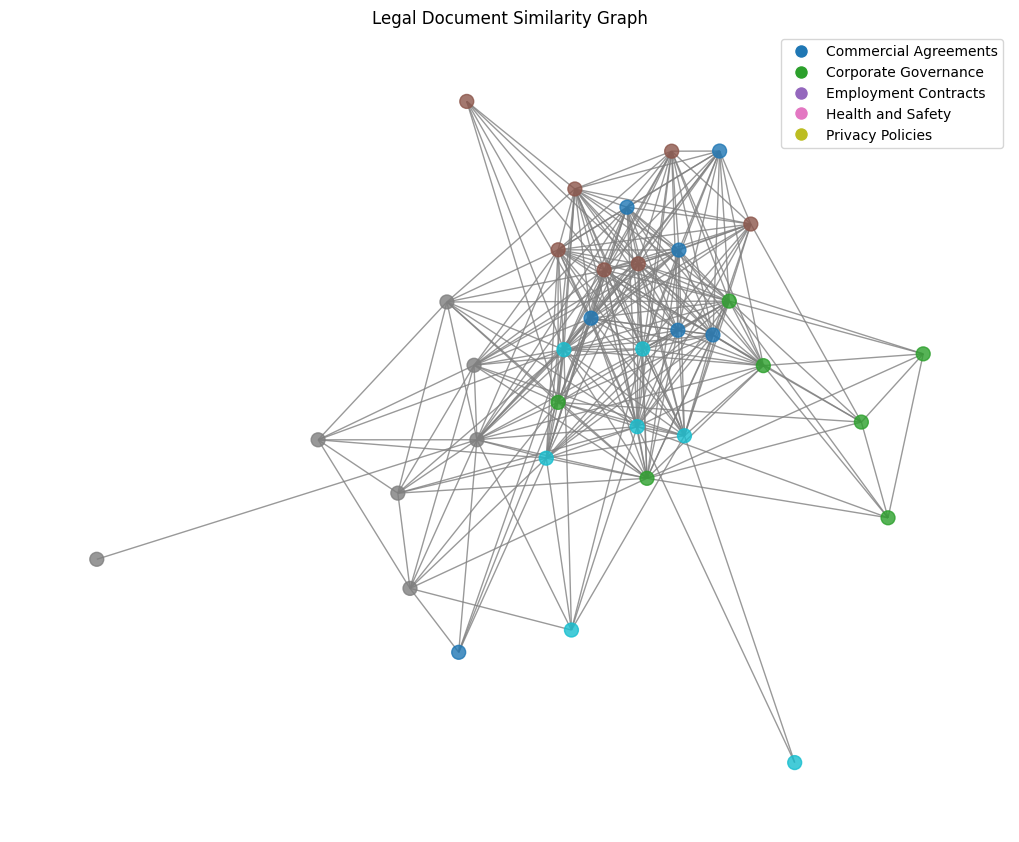

In [4]:
def build_document_graph(documents_df, embeddings, similarity_threshold=0.5):
    """
    Build a graph where:
    - Nodes are documents
    - Edges connect similar documents (based on cosine similarity)
    cosine similarity > measures how similar two vectors are, by looking at the angle between them
    """
    # Create networkx graph
    G = nx.Graph()

    # Add nodes with features
    for idx, row in documents_df.iterrows():
        G.add_node(
            row['id'],
            x=embeddings[idx],  # Node feature (document embedding)
            y=row['label'],     # Node label (document category)
            name=row['name'],
            category=row['category']
        )

    # Add edges based on document similarity
    for i in range(len(documents_df)):
        for j in range(i+1, len(documents_df)):
            # Calculate cosine similarity
            emb_i = embeddings[i]
            emb_j = embeddings[j]
            similarity = np.dot(emb_i, emb_j) / (np.linalg.norm(emb_i) * np.linalg.norm(emb_j))

            # Add edge if similarity is above threshold
            if similarity > similarity_threshold:
                G.add_edge(i, j, weight=float(similarity))

    return G

# Build the document graph
similarity_threshold = 0.5  # Adjust this threshold based on your data
doc_graph = build_document_graph(docs_df, doc_embeddings, similarity_threshold)

# Print graph statistics
print(f"Graph has {doc_graph.number_of_nodes()} nodes and {doc_graph.number_of_edges()} edges")

# Visualize the graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(doc_graph, seed=42)
node_colors = [doc_graph.nodes[n]['y'] for n in doc_graph.nodes()]

nx.draw(doc_graph, pos, with_labels=False, node_color=node_colors,
        cmap=plt.cm.tab10, node_size=100, alpha=0.8, edge_color='gray')

# Add a legend
labels = {i: cat for i, cat in enumerate(label_encoder.classes_)}
legend_colors = {cat: plt.cm.tab10(i/num_classes) for i, cat in labels.items()}
legend_patches = [plt.Line2D([0], [0], marker='o', color='w',
                           markerfacecolor=color, markersize=10, label=cat)
                for cat, color in legend_colors.items()]
plt.legend(handles=legend_patches, loc='upper right')

plt.title('Legal Document Similarity Graph')
plt.tight_layout()
plt.show()

### **Prepare PyTorch Geometric Data Object**

In [5]:
def prepare_pyg_data(graph):
    """Convert NetworkX graph to PyTorch Geometric Data object."""
    # Extract node features and labels
    nodes = list(graph.nodes(data=True))

    # Create feature matrix (x) and label vector (y)
    x = torch.stack([torch.tensor(data['x'], dtype=torch.float) for _, data in nodes])
    y = torch.tensor([data['y'] for _, data in nodes], dtype=torch.long)

    # Create edge index tensor
    edge_index = torch.tensor([[u, v] for u, v in graph.edges()], dtype=torch.long).t().contiguous()

    # Create edge weight tensor if available
    edge_attr = None
    first_edge = next(iter(graph.edges(data=True)), None)
    if first_edge and 'weight' in first_edge[2]:
        edge_attr = torch.tensor(
            [graph.edges[u, v]['weight'] for u, v in graph.edges()],
            dtype=torch.float
        ).view(-1, 1)

    # Create PyG Data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)

    return data

# Convert to PyG Data object
pyg_data = prepare_pyg_data(doc_graph)
print(f"PyG Data object: {pyg_data}")

# Split data into train and test sets
# For node classification, we split the nodes, not the entire graph
node_indices = torch.arange(pyg_data.num_nodes)
train_idx, test_idx = train_test_split(node_indices, test_size=0.2, random_state=42,
                                      stratify=pyg_data.y)

# Convert to tensor
train_idx = torch.tensor(train_idx, dtype=torch.long)
test_idx = torch.tensor(test_idx, dtype=torch.long)

PyG Data object: Data(x=[35, 1024], edge_index=[2, 275], edge_attr=[275, 1], y=[35])


C:\Users\npafe\AppData\Local\Temp\ipykernel_17592\2072800617.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_idx = torch.tensor(train_idx, dtype=torch.long)
C:\Users\npafe\AppData\Local\Temp\ipykernel_17592\2072800617.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_idx = torch.tensor(test_idx, dtype=torch.long)


### **Define the GNN Model**

In [6]:
class GNNModel(torch.nn.Module): #Graph Convolutional Network
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GNNModel, self).__init__()
        # First Graph Convolutional layer
        self.conv1 = GCNConv(input_dim, hidden_dim)
        # Second Graph Convolutional layer
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        # Output layer
        self.classifier = torch.nn.Linear(hidden_dim, output_dim)
        # Dropout for regularization
        self.dropout = torch.nn.Dropout(0.3)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        # First conv layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)

        # Second conv layer
        x = self.conv2(x, edge_index)
        x = F.relu(x)

        # Output layer
        x = self.classifier(x)

        return x

# Alternative model using GraphSAGE
class GraphSAGEModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphSAGEModel, self).__init__()
        self.sage1 = GraphSAGE(input_dim, hidden_dim, num_layers=2)
        self.classifier = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.sage1(x, edge_index)
        x = self.classifier(x)
        return x

# Initialize model
input_dim = pyg_data.num_node_features  # Document embedding dimension
hidden_dim = 64
output_dim = num_classes  # Number of document categories

# Choose which model to use
use_graphsage = False  # Set to True to use GraphSAGE instead of GCN
if use_graphsage:
    model = GraphSAGEModel(input_dim, hidden_dim, output_dim)
else:
    model = GNNModel(input_dim, hidden_dim, output_dim)

print(model)

GNNModel(
  (conv1): GCNConv(1024, 64)
  (conv2): GCNConv(64, 64)
  (classifier): Linear(in_features=64, out_features=5, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
)


### **Train the GNN Model**

Epoch  20, Loss: 0.8869, Test Acc: 1.0000
Epoch  40, Loss: 0.5671, Test Acc: 0.8571
Epoch  60, Loss: 0.3169, Test Acc: 0.8571
Epoch  80, Loss: 0.3837, Test Acc: 0.7143
Epoch 100, Loss: 0.5323, Test Acc: 0.8571
Epoch 120, Loss: 0.2668, Test Acc: 1.0000
Epoch 140, Loss: 0.2328, Test Acc: 1.0000
Epoch 160, Loss: 0.2780, Test Acc: 1.0000
Epoch 180, Loss: 0.2001, Test Acc: 1.0000
Epoch 200, Loss: 0.1805, Test Acc: 0.8571
Epoch 220, Loss: 0.1010, Test Acc: 1.0000
Epoch 240, Loss: 0.1084, Test Acc: 1.0000
Epoch 260, Loss: 0.0716, Test Acc: 0.8571
Epoch 280, Loss: 0.3308, Test Acc: 0.8571
Epoch 300, Loss: 0.1148, Test Acc: 1.0000
Epoch 320, Loss: 0.2612, Test Acc: 1.0000
Epoch 340, Loss: 0.1772, Test Acc: 1.0000
Epoch 360, Loss: 0.1677, Test Acc: 1.0000
Epoch 380, Loss: 0.1008, Test Acc: 0.8571
Epoch 400, Loss: 0.0841, Test Acc: 1.0000
Epoch 420, Loss: 0.1007, Test Acc: 1.0000
Epoch 440, Loss: 0.3609, Test Acc: 0.8571
Epoch 460, Loss: 0.1152, Test Acc: 1.0000
Epoch 480, Loss: 0.1054, Test Acc:

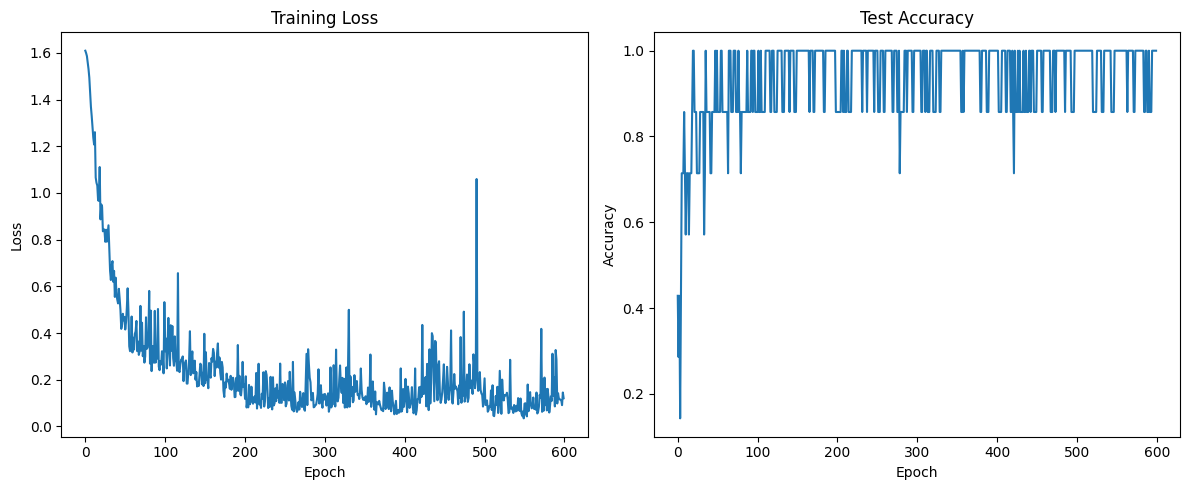

In [9]:
def train_gnn(model, data, train_idx, test_idx, epochs=300, lr=0.01):
    """Train the GNN model."""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    criterion = torch.nn.CrossEntropyLoss()

    best_test_acc = 0
    train_losses = []
    test_accs = []

    # Training loop
    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()

        # Forward pass
        out = model(data)
        loss = criterion(out[train_idx], data.y[train_idx])

        # Backward pass
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())

        # Evaluation
        model.eval()
        with torch.no_grad():
            out = model(data)
            pred = out.argmax(dim=1)

            # Calculate test accuracy
            correct = (pred[test_idx] == data.y[test_idx]).sum()
            test_acc = int(correct) / len(test_idx)
            test_accs.append(test_acc)

            if test_acc > best_test_acc:
                best_test_acc = test_acc

        # Print progress every 20 epochs
        if (epoch+1) % 20 == 0:
            print(f'Epoch {epoch+1:3d}, Loss: {loss.item():.4f}, Test Acc: {test_acc:.4f}')

    print(f"Best test accuracy: {best_test_acc:.4f}")

    # Plot training curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(test_accs)
    plt.title('Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

    return model, best_test_acc

# Train the model
trained_model, best_acc = train_gnn(model, pyg_data, train_idx, test_idx, epochs=600)

### **Evaluate Model Performance**

Final test accuracy: 1.0000

Test Results:


,id,name,true_category,predicted_category,confidence,correct
0,25,Partnership Agreement,Commercial Agreements,Commercial Agreements,0.749884,True
1,27,Franchise Agreement,Commercial Agreements,Commercial Agreements,0.974568,True
2,16,Shareholders Agreement,Corporate Governance,Corporate Governance,0.872006,True
3,31,Accident Reporting Procedure,Health and Safety,Health and Safety,0.999994,True
4,32,Hazardous Materials Handling Policy,Health and Safety,Health and Safety,0.999998,True
5,4,Intellectual Property Rights,Employment Contracts,Employment Contracts,0.967231,True
6,11,Customer Data Consent Form,Privacy Policies,Privacy Policies,0.999928,True



Full dataset accuracy: 1.0000


<Figure size 1000x800 with 0 Axes>

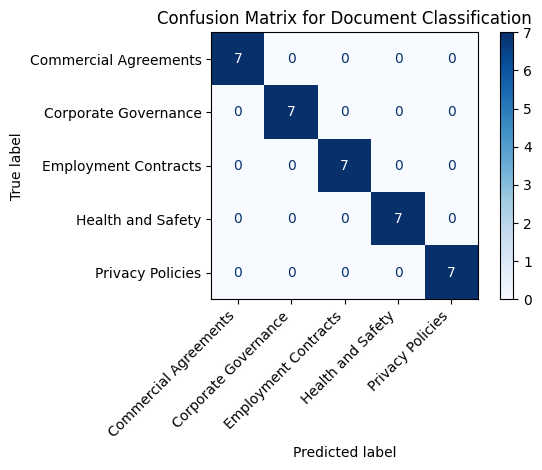

In [10]:
def evaluate_model(model, data, idx=None):
    """Evaluate model on specific indices or all data."""
    model.eval()
    with torch.no_grad():
        out = model(data)
        pred = out.argmax(dim=1)

        if idx is None:
            idx = torch.arange(data.num_nodes)

        # Calculate accuracy
        correct = (pred[idx] == data.y[idx]).sum()
        acc = int(correct) / len(idx)

        # Create confusion matrix
        y_true = data.y[idx].cpu().numpy()
        y_pred = pred[idx].cpu().numpy()

        # Get predictions and true labels
        predictions = []
        for i, idx_val in enumerate(idx):
            node_id = idx_val.item()
            true_label = label_encoder.classes_[y_true[i]]
            pred_label = label_encoder.classes_[y_pred[i]]
            confidence = F.softmax(out[idx_val], dim=0).max().item()

            predictions.append({
                'id': node_id,
                'name': docs_df.loc[node_id, 'name'],
                'true_category': true_label,
                'predicted_category': pred_label,
                'confidence': confidence,
                'correct': true_label == pred_label
            })

        return acc, pd.DataFrame(predictions)

# Evaluate on test set
test_acc, test_results = evaluate_model(trained_model, pyg_data, test_idx)
print(f"Final test accuracy: {test_acc:.4f}")

# Display test results
print("\nTest Results:")
display(test_results)

# Evaluate on all data
full_acc, all_results = evaluate_model(trained_model, pyg_data)
print(f"\nFull dataset accuracy: {full_acc:.4f}")

# Show confusion matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = all_results['true_category']
y_pred = all_results['predicted_category']

cm = confusion_matrix(y_true, y_pred, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)

plt.figure(figsize=(10, 8))
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=45, ha='right')
plt.title('Confusion Matrix for Document Classification')
plt.tight_layout()
plt.show()

### **Node Embeddings Visualization**

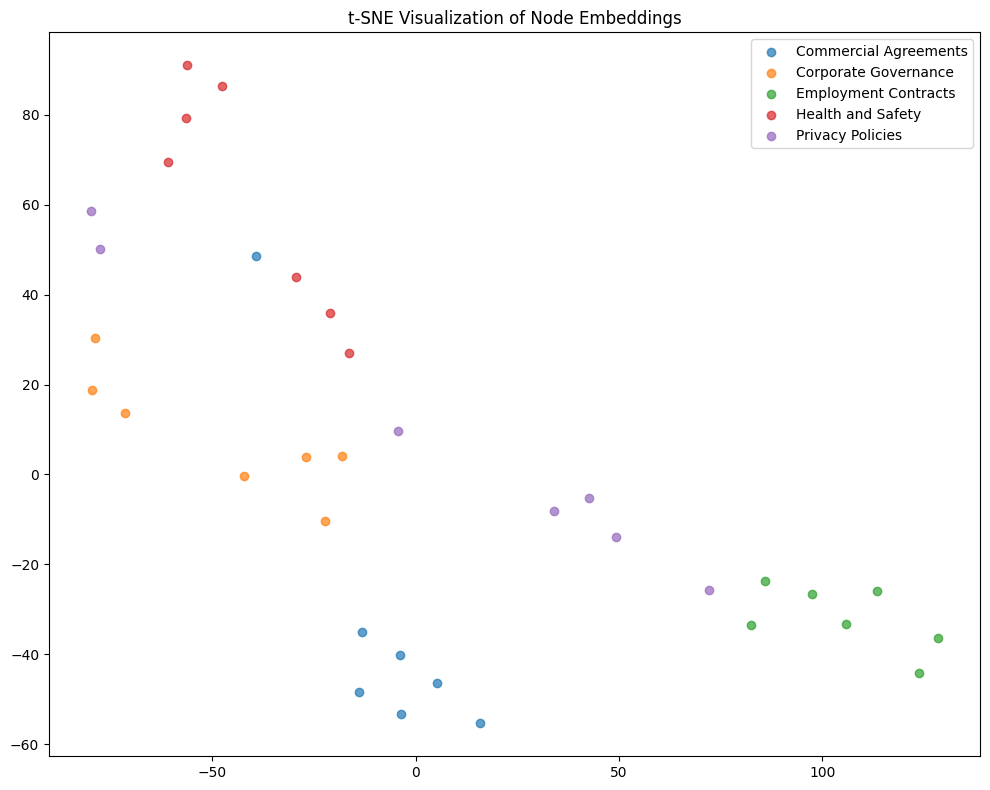

In [11]:
def visualize_node_embeddings(model, data):
    """Visualize node embeddings after GNN processing."""
    model.eval()
    with torch.no_grad():
        # Get node embeddings from the first GCN or GraphSAGE layer
        if hasattr(model, 'conv1'):
            embeddings = model.conv1(data.x, data.edge_index)
        else:
            embeddings = model.sage1(data.x, data.edge_index)

    # Reduce dimensions for visualization
    from sklearn.manifold import TSNE
    tsne = TSNE(n_components=2, perplexity=5, random_state=42)
    node_embeddings_2d = tsne.fit_transform(embeddings.cpu().numpy())

    # Plot
    plt.figure(figsize=(10, 8))
    for i in range(num_classes):
        mask = data.y.cpu().numpy() == i
        plt.scatter(
            node_embeddings_2d[mask, 0],
            node_embeddings_2d[mask, 1],
            label=label_encoder.classes_[i],
            alpha=0.7
        )

    plt.legend()
    plt.title('t-SNE Visualization of Node Embeddings')
    plt.tight_layout()
    plt.show()

# Visualize node embeddings
visualize_node_embeddings(trained_model, pyg_data)

### **Save the Model and Results**

In [ ]:
def save_model_and_results(model, data, docs_df, results_df, output_dir='../model_output'):
    """Save the trained model, graph data, and results."""
    import os
    import pickle

    # Create output directory if it doesn't exist
    os.makedirs(output_dir, exist_ok=True)

    # Save the model
    torch.save(model.state_dict(), os.path.join(output_dir, 'gnn_model.pt'))

    # Save the graph data
    torch.save(data, os.path.join(output_dir, 'graph_data.pt'))

    # Save the documents dataframe
    docs_df.to_pickle(os.path.join(output_dir, 'documents.pkl'))

    # Save the results
    results_df.to_csv(os.path.join(output_dir, 'classification_results.csv'), index=False)

    # Save label encoder
    with open(os.path.join(output_dir, 'label_encoder.pkl'), 'wb') as f:
        pickle.dump(label_encoder, f)

    print(f"Model and results saved to {output_dir}")

# Save everything
save_model_and_results(trained_model, pyg_data, docs_df, all_results)

Model and results saved to /content/model_output


# **Link Prediction for Legal Document Relationships**

### **Link Prediction Setup**

In [7]:
# Let's continue from our previous notebook by setting up link prediction functionality
print("Enhancing the legal document graph with link prediction capabilities...")

# Import additional libraries needed for link prediction
from torch_geometric.transforms import RandomLinkSplit
from sklearn.metrics import roc_auc_score, average_precision_score
import torch.nn as nn

Enhancing the legal document graph with link prediction capabilities...


### **Create Training Data for Link Prediction**

In [8]:
def prepare_link_prediction_data(pyg_data, val_ratio=0.1, test_ratio=0.1):
    """
    Prepare data for link prediction by splitting edges into train/val/test sets.

    Args:
        pyg_data: PyTorch Geometric Data object containing the graph
        val_ratio: Ratio of edges to use for validation
        test_ratio: Ratio of edges to use for testing

    Returns:
        train_data, val_data, test_data: Data objects for training, validation and testing
    """
    # Create a transform that randomly splits links
    transform = RandomLinkSplit(
        num_val=val_ratio,
        num_test=test_ratio,
        is_undirected=True,
        add_negative_train_samples=True,
        neg_sampling_ratio=1.0,  # 1:1 ratio of positive to negative samples
    )

    # Split the data
    train_data, val_data, test_data = transform(pyg_data)

    print(f"Training edges: {train_data.edge_index.size(1)//2}")
    print(f"Validation edges: {val_data.edge_index.size(1)//2}")
    print(f"Testing edges: {test_data.edge_index.size(1)//2}")

    return train_data, val_data, test_data

# Split the data for link prediction
train_data, val_data, test_data = prepare_link_prediction_data(pyg_data)

Training edges: 221
Validation edges: 221
Testing edges: 248


### **Define the Link Prediction Model**

In [14]:
from torch_geometric.nn import SAGEConv


class LinkPredictionGNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, embedding_dim):
        super(LinkPredictionGNN, self).__init__()
        # GNN layers for node embedding
        # self.conv1 = GCNConv(input_dim, hidden_dim)
        # self.conv2 = GCNConv(hidden_dim, embedding_dim)
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, embedding_dim)

        # Link predictor (dot product and sigmoid will be applied outside)
        self.dropout = nn.Dropout(0.3)

        # Update decoder to output a single value
        self.decoder = nn.Sequential(
            nn.Linear(embedding_dim * 4, 32), #takes the concatenated embeddings and reduces them to 64 features
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, 1) # Further reduces to a single output value for each edge
        )

        # Proper weight initialization
        self.reset_parameters()

        
    def reset_parameters(self):
        # Xavier initialization for weights
        for module in self.decoder:
            if isinstance(module, nn.Linear):
                torch.nn.init.xavier_uniform_(module.weight)
                if module.bias is not None:
                    torch.nn.init.zeros_(module.bias)


    def encode(self, x, edge_index):
        """Encode nodes to embeddings."""
        # First GNN layer
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)

        # Second GNN layer
        x = self.conv2(x, edge_index)
        # L2 normalization of embeddings helps prevent overfitting
        x = F.normalize(x, p=2, dim=1)
        return x

    def decode(self, z, edge_index):
        """Decode embeddings to edge predictions."""
        # Get node embeddings for the source and target nodes
        src, dst = edge_index

        # Concatenate embeddings and pass them through the decoder to get a single output value.
        link_pred = self.decoder(torch.cat([z[src], z[dst], z[src] * z[dst], torch.abs(z[src] - z[dst])], dim=1))

        #squeeze removes the extra dimension of size 1, making the output have size [442]
        return link_pred.squeeze(1)

    def decode_all(self, z):
        """Decode all possible node pairs."""
        # Create a matrix of all possible node pair scores
        # This is computationally expensive for large graphs!
        prob_adj = z @ z.t()
        return prob_adj

    def forward(self, x, edge_index, edge_label_index):
        """Forward pass for link prediction."""
        # Get node embeddings
        z = self.encode(x, edge_index)

        # Predict links for the specified edges
        link_pred = self.decode(z, edge_label_index)

        return link_pred, z

# Initialize the link prediction model
embedding_dim = 64
link_pred_model = LinkPredictionGNN(input_dim, hidden_dim, embedding_dim)
print(link_pred_model)

LinkPredictionGNN(
  (conv1): SAGEConv(1024, 64, aggr=mean)
  (conv2): SAGEConv(64, 64, aggr=mean)
  (dropout): Dropout(p=0.3, inplace=False)
  (decoder): Sequential(
    (0): Linear(in_features=256, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=32, out_features=1, bias=True)
  )
)


### **Train the Link Prediction Model**

Epoch  10, Loss: 0.6467, Val AUC: 0.8272
Epoch  20, Loss: 0.5847, Val AUC: 0.8532
Epoch  30, Loss: 0.5407, Val AUC: 0.8642
Epoch  40, Loss: 0.4892, Val AUC: 0.8738
Epoch  50, Loss: 0.4592, Val AUC: 0.8779
Epoch  60, Loss: 0.4156, Val AUC: 0.9067
Epoch  70, Loss: 0.3730, Val AUC: 0.9204
Epoch  80, Loss: 0.3528, Val AUC: 0.9191
Epoch  90, Loss: 0.3330, Val AUC: 0.9300
Epoch 100, Loss: 0.3249, Val AUC: 0.9369
Epoch 110, Loss: 0.3207, Val AUC: 0.9383
Epoch 120, Loss: 0.2969, Val AUC: 0.9369
Epoch 130, Loss: 0.2798, Val AUC: 0.9355
Epoch 140, Loss: 0.2637, Val AUC: 0.9369
Epoch 150, Loss: 0.2501, Val AUC: 0.9479
Epoch 160, Loss: 0.2582, Val AUC: 0.9383
Epoch 170, Loss: 0.2556, Val AUC: 0.9438
Epoch 180, Loss: 0.2631, Val AUC: 0.9451
Epoch 190, Loss: 0.2584, Val AUC: 0.9396
Epoch 200, Loss: 0.2514, Val AUC: 0.9396
Epoch 210, Loss: 0.2441, Val AUC: 0.9410
Epoch 220, Loss: 0.2552, Val AUC: 0.9410
Epoch 230, Loss: 0.2473, Val AUC: 0.9396
Epoch 240, Loss: 0.2365, Val AUC: 0.9396
Epoch 250, Loss:

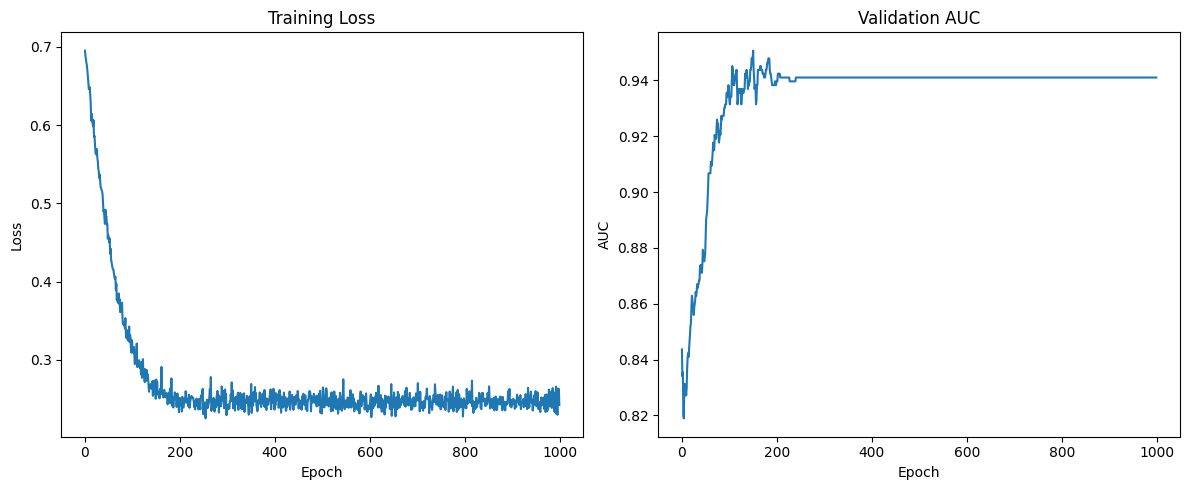

In [15]:
def train_link_prediction(model, train_data, val_data, epochs=100, lr=0.001):
    """Train the link prediction model with anti-overfitting measures."""
    # Add weight decay for L2 regularization
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.7, patience=10
    )
    
    criterion = torch.nn.BCEWithLogitsLoss()
    
    best_val_auc = 0
    best_model_state = None
    # patience = 20  # Early stopping patience
    counter = 0
    
    train_losses = []
    val_aucs = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        optimizer.zero_grad()
        
        # Forward pass
        link_logits, _ = model(
            train_data.x,
            train_data.edge_index,
            train_data.edge_label_index
        )
        
        # Calculate loss
        loss = criterion(link_logits, train_data.edge_label)
        
        # Add gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_link_logits, _ = model(
                val_data.x,
                val_data.edge_index,
                val_data.edge_label_index
            )
            
            val_link_probs = torch.sigmoid(val_link_logits)
            val_auc = roc_auc_score(val_data.edge_label.cpu().numpy(), val_link_probs.cpu().numpy())
            val_aucs.append(val_auc)
            
            # Update learning rate based on validation performance
            scheduler.step(val_auc)
            
            # Check if this is the best model so far
            if val_auc > best_val_auc:
                best_val_auc = val_auc
                # Save model state (to CPU to avoid potential CUDA memory issues)
                best_model_state = {k: v.cpu() for k, v in model.state_dict().items()}
                counter = 0
            else:
                counter += 1
            
            # # Early stopping check
            # if counter >= patience:
            #     print(f"Early stopping at epoch {epoch+1}")
            #     break
        
        # Print progress every 10 epochs
        if (epoch+1) % 10 == 0:
            print(f'Epoch {epoch+1:3d}, Loss: {loss.item():.4f}, Val AUC: {val_auc:.4f}')
    
    # Restore best model
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    print(f"Best validation AUC: {best_val_auc:.4f}")
    
    # Plot training curves as before
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    
    plt.subplot(1, 2, 2)
    plt.plot(val_aucs)
    plt.title('Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    
    plt.tight_layout()
    plt.show()
    
    return model, best_val_auc

# Train the link prediction model
trained_link_model, best_link_auc = train_link_prediction(link_pred_model, train_data, val_data, epochs=1000)

### **Evaluate Link Prediction Performance**

In [16]:
def evaluate_link_prediction(model, data):
    """Evaluate link prediction model on test data."""
    model.eval()
    with torch.no_grad():
        # Forward pass - predict test links
        test_link_logits, node_embeddings = model(
            data.x,
            data.edge_index,
            data.edge_label_index
        )

        # Convert logits to probabilities
        test_link_probs = torch.sigmoid(test_link_logits)

        # Calculate metrics
        test_auc = roc_auc_score(data.edge_label.cpu().numpy(), test_link_probs.cpu().numpy())
        test_ap = average_precision_score(data.edge_label.cpu().numpy(), test_link_probs.cpu().numpy())

        print(f"Test AUC: {test_auc:.4f}")
        print(f"Test AP: {test_ap:.4f}")

        # Create prediction results
        edge_pred = (test_link_probs > 0.5).float()
        accuracy = (edge_pred == data.edge_label).sum().item() / len(data.edge_label)
        print(f"Link prediction accuracy: {accuracy:.4f}")

        # Return embeddings for visualization
        return test_auc, test_ap, node_embeddings

# Evaluate on test data
test_auc, test_ap, node_embeddings = evaluate_link_prediction(trained_link_model, test_data)

Test AUC: 0.9794
Test AP: 0.9798
Link prediction accuracy: 0.9259


### **Visualize Document Relationships**

C:\Users\npafe\AppData\Local\Temp\ipykernel_17592\1174190168.py:57: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


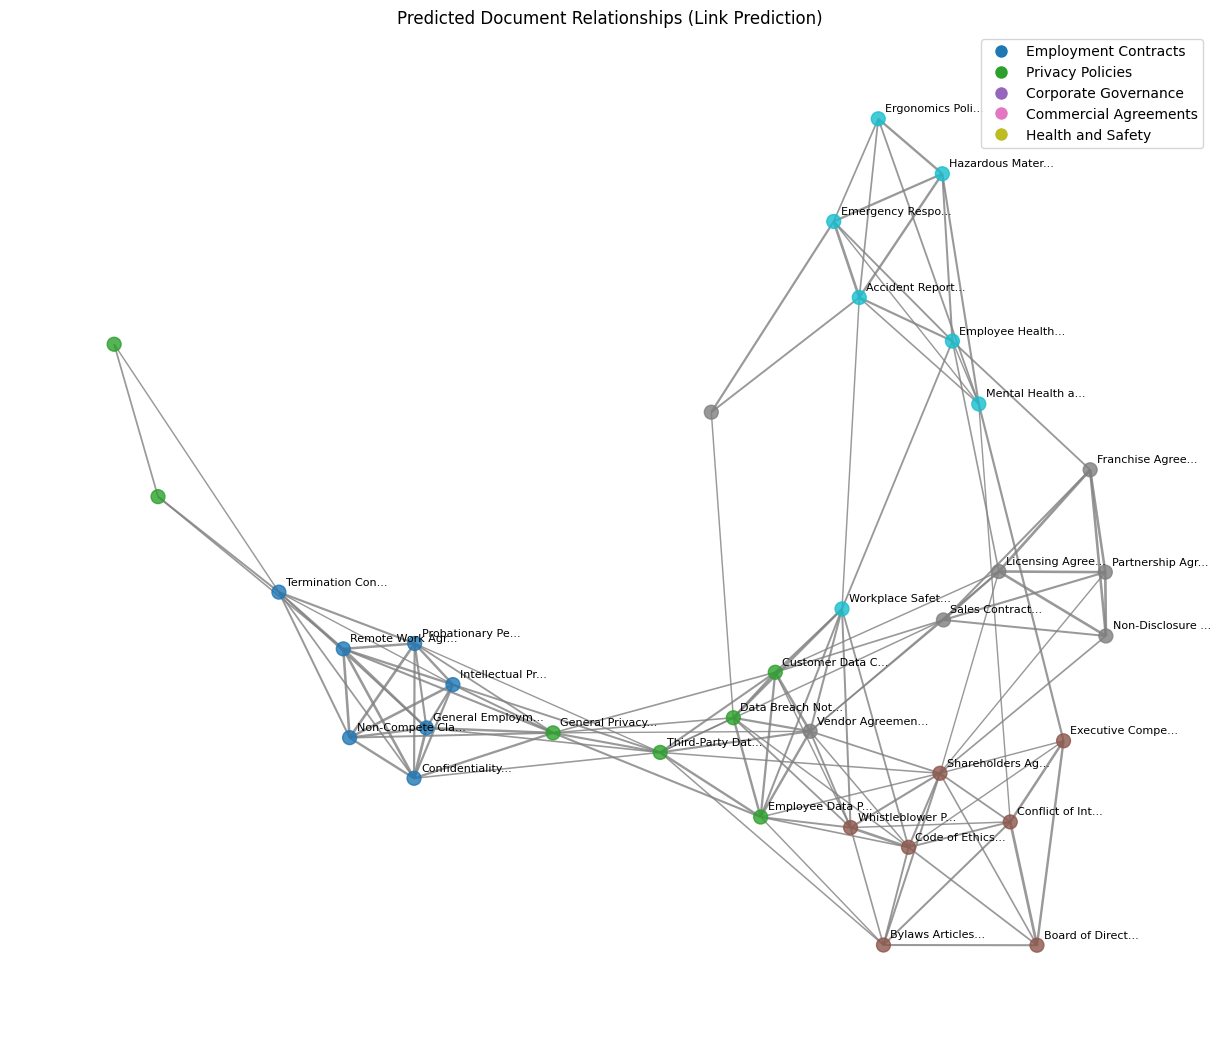

In [26]:
def visualize_document_relationships(node_embeddings, data, docs_df, threshold=0.7):
    """Visualize document relationships based on predicted links."""
    # Convert embeddings to numpy
    emb_matrix = node_embeddings.cpu().numpy()

    # Create a graph for visualization
    G_pred = nx.Graph()

    # Add nodes with attributes
    for i in range(len(docs_df)):
        G_pred.add_node(
            i,
            name=docs_df.iloc[i]['name'],
            category=docs_df.iloc[i]['category']
        )

    # Compute similarity matrix
    from sklearn.metrics.pairwise import cosine_similarity
    sim_matrix = cosine_similarity(emb_matrix)

    # Add edges for similar document pairs
    for i in range(len(docs_df)):
        for j in range(i+1, len(docs_df)):
            if sim_matrix[i, j] > threshold:
                G_pred.add_edge(i, j, weight=float(sim_matrix[i, j]))

    # Plot the graph
    plt.figure(figsize=(12, 10))

    # Use different colors for different categories
    category_colors = {cat: i for i, cat in enumerate(docs_df['category'].unique())}
    node_colors = [category_colors[docs_df.iloc[node]['category']] for node in G_pred.nodes()]

    # Use spring layout
    pos = nx.spring_layout(G_pred, seed=42)

    # Draw the graph
    nx.draw(G_pred, pos, with_labels=False, node_color=node_colors,
            cmap=plt.cm.tab10, node_size=100, alpha=0.8,
            edge_color='gray', width=[G_pred[u][v]['weight'] * 2 for u, v in G_pred.edges()])

    # Add legend for document categories
    categories = docs_df['category'].unique()
    legend_patches = [plt.Line2D([0], [0], marker='o', color='w',
                              markerfacecolor=plt.cm.tab10(category_colors[cat]/len(categories)),
                              markersize=10, label=cat) for cat in categories]
    plt.legend(handles=legend_patches, loc='upper right')

    # Add labels to some important nodes
    for node_id in G_pred.nodes():
        if G_pred.degree(node_id) > 3:  # Label nodes with many connections
            plt.annotate(docs_df.iloc[node_id]['name'][:15] + '...',
                       xy=pos[node_id], xytext=(5, 5),
                       textcoords='offset points', fontsize=8)

    plt.title('Predicted Document Relationships (Link Prediction)')
    plt.tight_layout()
    plt.show()

    return G_pred, sim_matrix

# Generate and visualize relationships
G_pred, similarity_matrix = visualize_document_relationships(node_embeddings, test_data, docs_df, threshold=0.5)

### **Document Recommendation Function**

In [18]:
def recommend_similar_documents(doc_id, similarity_matrix, docs_df, top_k=7):
    """Recommend similar documents for a given document."""
    # Get similarity scores for the document
    doc_similarities = similarity_matrix[doc_id]

    # Sort scores and get indices of most similar documents (excluding self)
    similar_doc_indices = doc_similarities.argsort()[::-1][1:top_k+1]

    recommendations = []
    for idx in similar_doc_indices:
        recommendations.append({
            'id': idx,
            'name': docs_df.iloc[idx]['name'],
            'category': docs_df.iloc[idx]['category'],
            'similarity_score': doc_similarities[idx]
        })

    return pd.DataFrame(recommendations)

# Example: Get recommendations for the first document
doc_id = 0
doc_name = docs_df.iloc[doc_id]['name']
print(f"Recommended documents similar to '{doc_name}':")
recommendations = recommend_similar_documents(doc_id, similarity_matrix, docs_df)
display(recommendations)

Recommended documents similar to 'General Employment Agreement':


,id,name,category,similarity_score
0,2,Confidentiality Agreement,Employment Contracts,0.985843
1,5,Remote Work Agreement,Employment Contracts,0.919469
2,7,General Privacy Policy,Privacy Policies,0.880086
3,1,Non-Compete Clause,Employment Contracts,0.851519
4,4,Intellectual Property Rights,Employment Contracts,0.818696
5,6,Probationary Period Agreement,Employment Contracts,0.774832
6,12,Third-Party Data Sharing Agreement,Privacy Policies,0.597002


### **Analyzing Cross-Category Relationships**

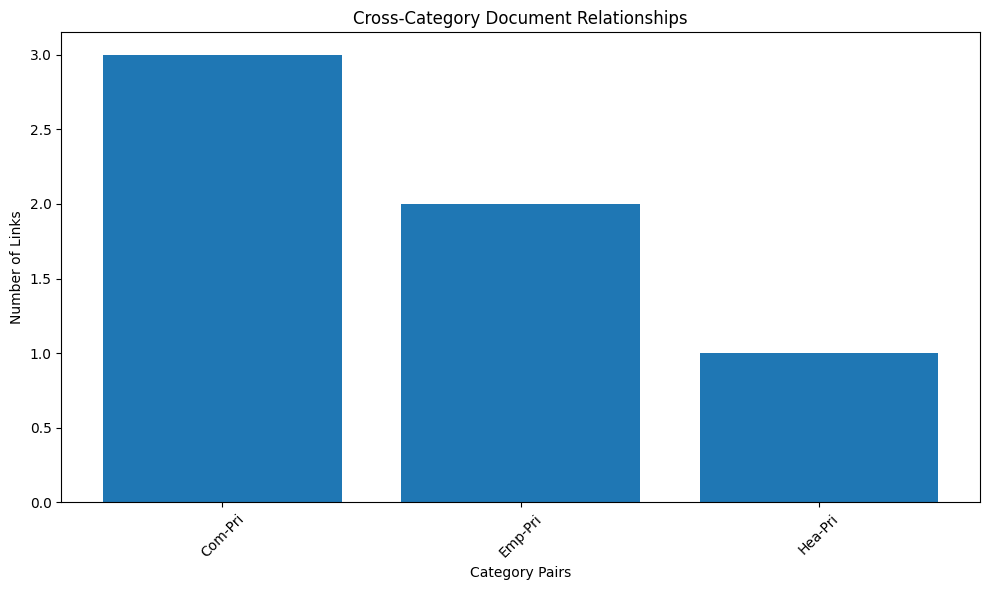

Top cross-category document relationships:


,doc1_id,doc1_name,doc1_category,doc2_id,doc2_name,doc2_category,similarity
3,11,Customer Data Consent Form,Privacy Policies,21,Vendor Agreement,Commercial Agreements,0.937845
0,0,General Employment Agreement,Employment Contracts,7,General Privacy Policy,Privacy Policies,0.880086
2,10,Employee Data Protection Agreement,Privacy Policies,21,Vendor Agreement,Commercial Agreements,0.872515
5,13,Data Breach Notification Policy,Privacy Policies,28,Workplace Safety Policy,Health and Safety,0.867754
1,2,Confidentiality Agreement,Employment Contracts,7,General Privacy Policy,Privacy Policies,0.830153
4,13,Data Breach Notification Policy,Privacy Policies,21,Vendor Agreement,Commercial Agreements,0.800709


In [20]:
def analyze_cross_category_links(graph, docs_df):
    """Analyze relationships between documents from different categories."""
    cross_category_links = []

    for u, v in graph.edges():
        cat_u = docs_df.iloc[u]['category']
        cat_v = docs_df.iloc[v]['category']

        if cat_u != cat_v:
            cross_category_links.append({
                'doc1_id': u,
                'doc1_name': docs_df.iloc[u]['name'],
                'doc1_category': cat_u,
                'doc2_id': v,
                'doc2_name': docs_df.iloc[v]['name'],
                'doc2_category': cat_v,
                'similarity': graph[u][v]['weight']
            })

    # Sort by similarity
    cross_cat_df = pd.DataFrame(cross_category_links).sort_values('similarity', ascending=False)

    # Count links between categories
    category_pairs = []
    for _, row in cross_cat_df.iterrows():
        cat_pair = tuple(sorted([row['doc1_category'], row['doc2_category']]))
        category_pairs.append(cat_pair)

    pair_counts = pd.Series(category_pairs).value_counts()

    # Visualize category relationships
    plt.figure(figsize=(10, 6))
    plt.bar(range(len(pair_counts)), pair_counts.values)
    plt.xticks(range(len(pair_counts)), [f"{p[0][:3]}-{p[1][:3]}" for p in pair_counts.index], rotation=45)
    plt.title('Cross-Category Document Relationships')
    plt.xlabel('Category Pairs')
    plt.ylabel('Number of Links')
    plt.tight_layout()
    plt.show()

    return cross_cat_df

# Analyze cross-category links
cross_category_df = analyze_cross_category_links(G_pred, docs_df)
print("Top cross-category document relationships:")
display(cross_category_df.head(10))

### **Predicting New Document Links**

### **Save the Link Prediction Model**